In [1]:
import numpy as np
import nibabel as nib
from scipy.stats import pearsonr, zscore
from scipy.signal import convolve
from brainiak_utils import _double_gamma_hrf, convolve_hrf
from sklearn.linear_model import Ridge, RidgeCV
from scipy.fftpack import dct
from scipy.linalg import toeplitz
from nilearn.signal import clean
from nilearn.image import get_data
import seaborn as sns
sns.set_context('poster')
%config InLineBackend.figure_format = 'rentina'


#fast masking function
def apply_mask(mask=None,target=None):
    coor = np.where(mask == 1)
    values = target[coor]
    if values.ndim > 1:
        values = np.transpose(values) #swap axes to get feature X sample
    return values

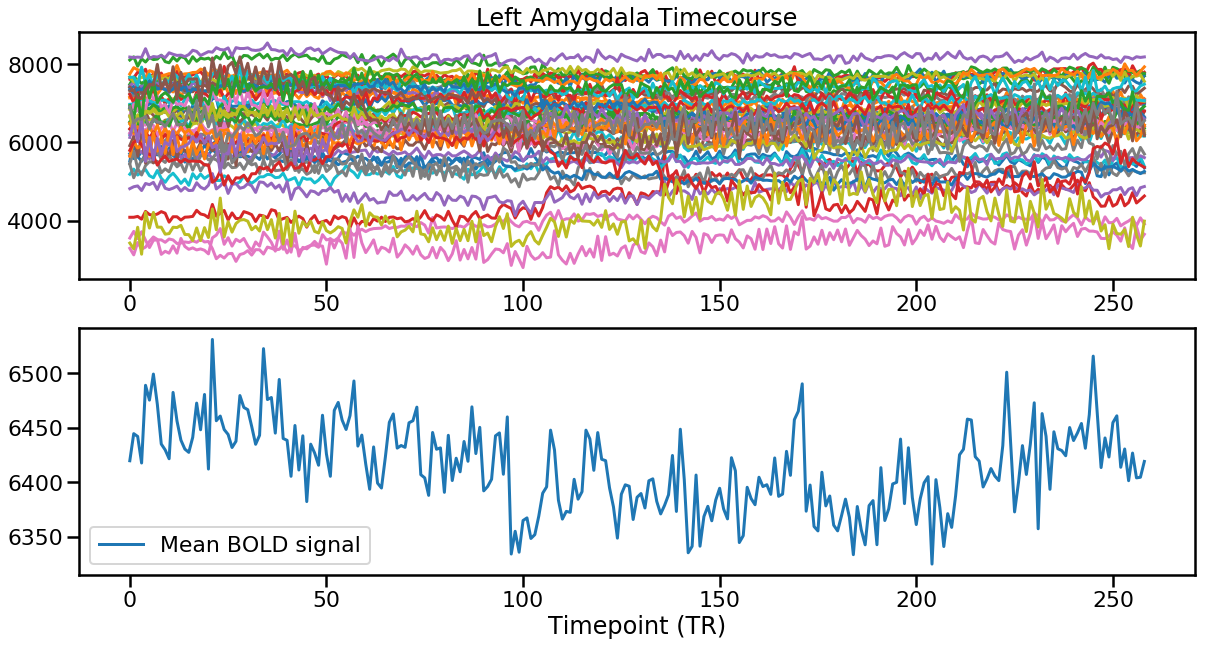

In [2]:
data = get_data('example_data/sub-FC004_ses-1_task-acquisition_space-T1w_desc-preproc_bold.nii.gz')
mask = get_data('example_data/lh_amyg.nii.gz')
data = apply_mask(mask=mask,target=data)
bold = data.mean(axis=1)
x = range(bold.shape[0])
fig, ax = plt.subplots(2,figsize=(20,10))
ax[0].plot(x,data)
ax[0].set_title('Left Amygdala Timecourse')
ax[1].plot(x,bold,label='Mean BOLD signal');
plt.legend();
plt.xlabel('Timepoint (TR)');

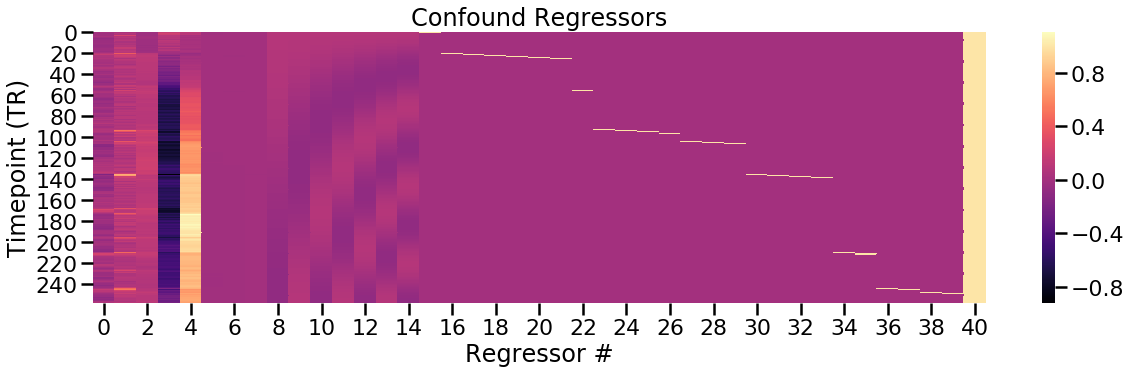

In [3]:
confounds = pd.read_csv('example_data/confounds.txt',sep='\t',header=None).values
# confounds = confounds[:,:15]
# confounds_dt = np.hstack((confounds,np.ones((confounds.shape[0],1))))
plt.figure(figsize=(20,5))
sns.heatmap(confounds,cmap='magma');
plt.title('Confound Regressors');
plt.ylabel('Timepoint (TR)');
plt.xlabel('Regressor #');

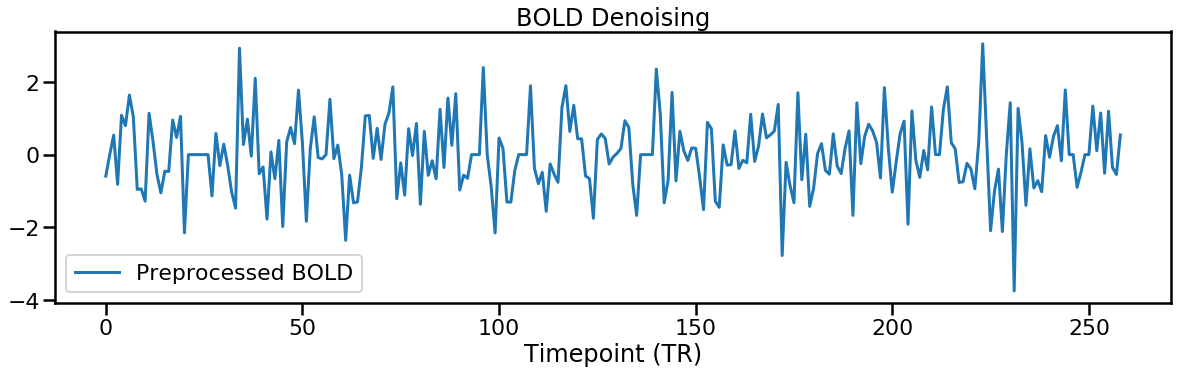

In [4]:
preproc = clean(bold[:,np.newaxis],confounds=confounds,t_r=2,detrend=False,standardize='zscore')
plt.figure(figsize=(20,5))
plt.plot(x,preproc,label='Preprocessed BOLD');
plt.legend();
plt.title('BOLD Denoising');
plt.xlabel('Timepoint (TR)');

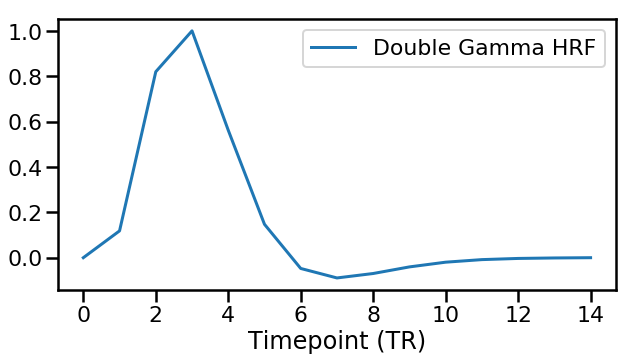

In [5]:
#set up parameters for deconvolution
N = preproc.shape[0]
TR = 2
hrf = np.array(_double_gamma_hrf(temporal_resolution=.5))
hrf /= np.max(hrf)
plt.figure(figsize=(10,5))
plt.plot(hrf,label='Double Gamma HRF');
plt.legend();
plt.xlabel('Timepoint (TR)');

In [6]:
#make the cosine basis set
def dct_mat(N_,K_):
    n = np.array((range(0,N_))).T
    C_ = np.zeros((n.shape[0],K_))
    C_[:,0] = np.ones(n.shape[0])/np.sqrt(N_)
    for q in range(1,K_):
        C_[:,q] = np.sqrt(2/N_)* np.cos( np.pi*(2*n)* (q) /(2*N_))
    return C_

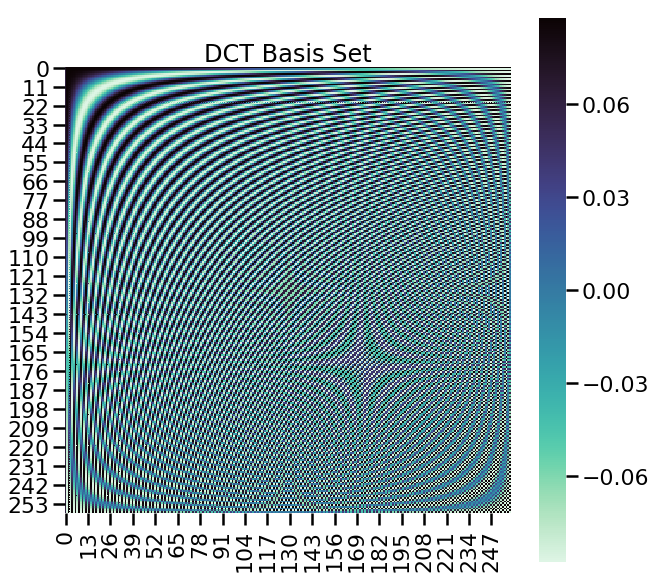

In [7]:
xb = dct_mat(N,N)
plt.figure(figsize=(10,10))
sns.heatmap(xb,cmap='mako_r',square=True);
plt.title('DCT Basis Set');

In [8]:
#Convolve the basis set with the HRF
Hxb = np.zeros((N,N))
for i in range(N):
    Hx = convolve(xb[:,i],hrf)[:N]
    Hxb[:,i] = Hx

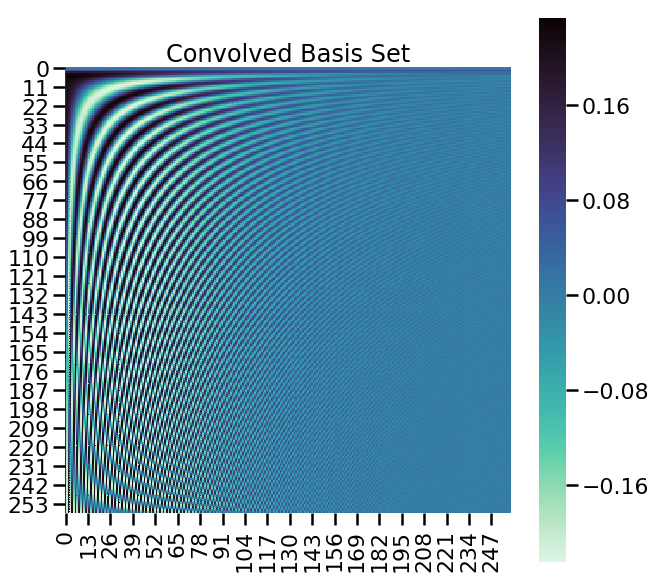

In [9]:
plt.figure(figsize=(10,10))
sns.heatmap(Hxb,cmap='mako_r',square=True);
plt.title('Convolved Basis Set');

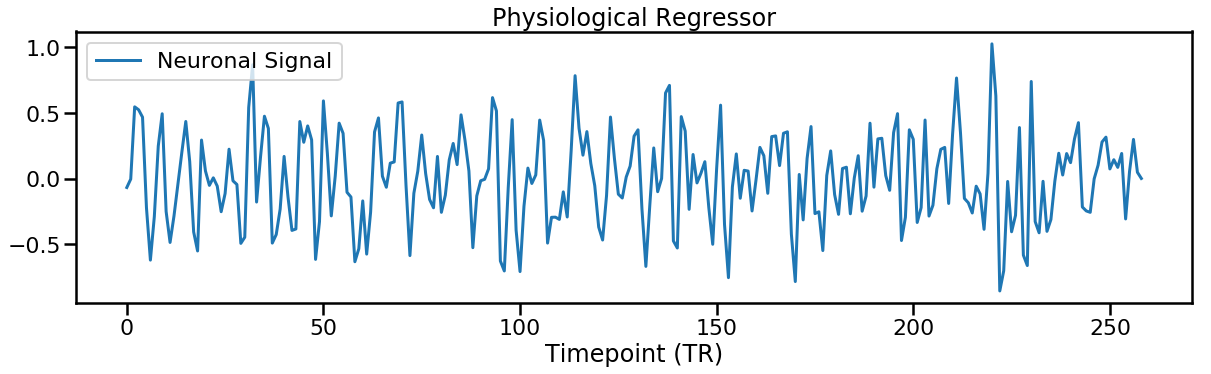

In [10]:
reg = Ridge(alpha=1,solver='lsqr',fit_intercept=False,normalize=False,max_iter=1000)
reg.fit(Hxb,preproc)
neuronal = np.matmul(xb,reg.coef_[0,:])
plt.figure(figsize=(20,5))
plt.plot(x,neuronal,label='Neuronal Signal')
plt.legend();
plt.xlabel('Timepoint (TR)');
plt.title('Physiological Regressor');

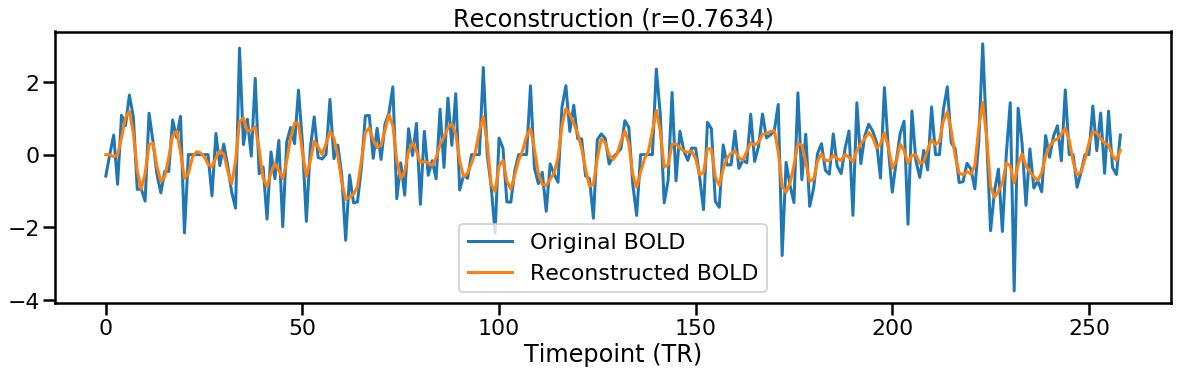

In [11]:
recon = convolve(neuronal , hrf)[:bold.shape[0]]
plt.figure(figsize=(20,5))
plt.plot(x,preproc,label='Original BOLD')
plt.plot(x,recon,label='Reonstructed BOLD')
plt.legend(['Original BOLD','Reconstructed BOLD']);
plt.xlabel('Timepoint (TR)');
plt.title('Reconstruction (r=%s)'%(np.round(pearsonr(preproc[:,0],recon)[0],4)));

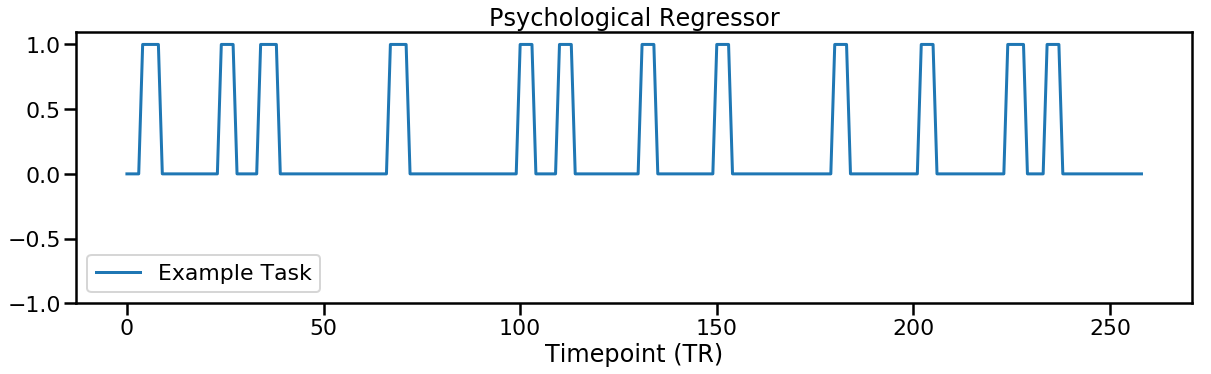

In [12]:
#make some test regressors
labels = pd.read_csv('../../nistats-bids/sub-FC001/ses-1/func/sub-FC001_ses-1_task-acquisition_events.tsv',sep='\t')
labels = labels[labels.trial_type == 'CS+'][['onset','duration']].round()
design = np.zeros(N)
for i in labels.index:
    onset = int(labels.loc[i,'onset'])
    duration = int(labels.loc[i,'duration'])
    design[onset:onset+duration] = 1
plt.figure(figsize=(20,5))
plt.plot(x,design);
plt.ylim(-1,1.1)
plt.legend(['Example Task']);
plt.title('Psychological Regressor')
plt.xlabel('Timepoint (TR)');

Text(0.5, 1.0, 'Psychological x Physiological Interaction')

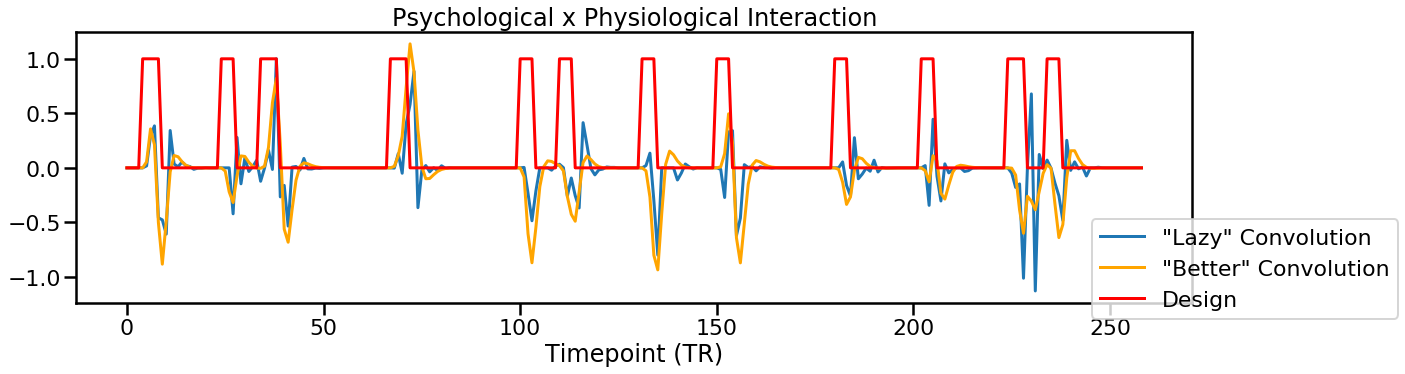

In [13]:
lazy = convolve(design,hrf)[:N] * preproc[:,0]
lazy /= lazy.max()
better = convolve(neuronal*design,hrf)[:N]

fig, ax = plt.subplots(figsize=(20,5))
plt.plot(x,lazy,label='"Lazy" Convolution')
plt.plot(x,better,color='orange',label='"Better" Convolution')
plt.plot(x,design,color='red',label='Design')
plt.legend(bbox_to_anchor=(.9, .35));
plt.xlabel('Timepoint (TR)');
plt.title('Psychological x Physiological Interaction')